<span style="font-size: 30px; font-weight: bold;">Data Wrangling Overview </span>

<span style="font-size: 16px; font-weight: bold;">Description from Kaggel competition: </span>

M5 Forecasting - Accuracy 
In the challenge, you will use hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy. This competition uses a Weighted Root Mean Squared Scaled Error (RMSSE).
Predicting unit sales for days 1914-1941

## Table of Contents

- [Load Datasets](#load-datasets)
- [Review Sales Data](#review-sales-data)
- [Review Price Data](#review-price-data)
- [Review Calendar Data](#review-calendar-data)
- [Changing sales_df to Panel View](#changing-sales-df-to-panel-view)
- [Joining Sales, Calendar, and Price Dataframes](#joining-sales-calendar-and-price-dataframes)
- [Fixing NaN's on sell_price](#fixing-nans-on-sell-price)
- [Final Adjustments to sales_df and Saving](#final-adjustments-to-sales-df-and-saving)
- [Data Wrangling Summary](#summary)


In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import os
from pathlib import Path

<span id="load-datasets" style="font-size: 30px; font-weight: bold;">Load Datasets</span>

In [2]:
calendar_df = pd.read_csv(r"C:\Users\brian\Desktop\Time Series Predict Unit Sales for Walmart\Data\calendar.csv")
price_df = pd.read_csv(r"C:\Users\brian\Desktop\Time Series Predict Unit Sales for Walmart\Data\sell_prices.csv")
sales_df = pd.read_csv(r"C:\Users\brian\Desktop\Time Series Predict Unit Sales for Walmart\Data\sales_train_validation.csv")

<span id="review-sales-data" style="font-size: 16px; font-weight: bold;">Review Sales Data</span>

In [3]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [4]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [5]:
# This is a unique id for each item in each store so 3,049 items X 10 stores = 30,490 unique item ids
sales_df['id'].nunique()

30490

In [6]:
# There should be 3,049 products in the dataset
sales_df['item_id'].nunique()

3049

In [7]:
# There are three states in the dataset CA, TX and WI
sales_df['state_id'].nunique()

3

In [8]:
# There Should be 10 Store ID's 
unique_store_ids = sales_df['store_id'].unique()
count_unique_store_ids = sales_df['store_id'].nunique()

print("Unique store_ids:", unique_store_ids)
print("Count of unique store_ids:", count_unique_store_ids)

Unique store_ids: ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
Count of unique store_ids: 10


In [9]:
# There Should be 3 product categories: Hobbies, Food and Household 
unique_cat_ids = sales_df['cat_id'].unique()
count_unique_cat_ids = sales_df['cat_id'].nunique()

print("Unique cat_ids:", unique_cat_ids)
print("Count of unique cat_ids:", count_unique_cat_ids)

Unique cat_ids: ['HOBBIES' 'HOUSEHOLD' 'FOODS']
Count of unique cat_ids: 3


In [10]:
# There Should be 7 Departments 
unique_dept_ids = sales_df['dept_id'].unique()
count_unique_dept_ids = sales_df['dept_id'].nunique()

print("Unique dept_ids:", unique_dept_ids)
print("Count of unique dept_ids:", count_unique_dept_ids)

Unique dept_ids: ['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']
Count of unique dept_ids: 7


In [11]:
unique_item_ids = sales_df['item_id'].unique()
count_unique_item_ids = sales_df['item_id'].nunique()

print("Unique item_ids:", unique_item_ids)
print("Count of unique item_ids:", count_unique_item_ids)

Unique item_ids: ['HOBBIES_1_001' 'HOBBIES_1_002' 'HOBBIES_1_003' ... 'FOODS_3_825'
 'FOODS_3_826' 'FOODS_3_827']
Count of unique item_ids: 3049


<span style="font-size: 16px;">Changing Dtypes from Object to Category </span>

In [12]:
columns_to_convert = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
sales_df[columns_to_convert] = sales_df[columns_to_convert].astype("category")

In [13]:
sales_df.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,129.000000,160.000000,204.000000,98.000000,100.000000,88.000000,77.000000,141.000000,171.000000,130.000000


In [14]:
missing_values = pd.concat([sales_df.isnull().sum(), 100 * sales_df.isnull().mean()], axis=1)
missing_values.columns = ['count', '%']
missing_values.sort_values(by='count', ascending=False, inplace=True)
missing_sort = missing_values.query('count > 0')
missing_sort.sort_values(by = 'count', ascending = False)

,count,%


<span id="review-price-data" style="font-size: 16px; font-weight: bold;">Review Price Data</span>

<span style="font-size: 16px;">Notes about sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).  </span>

In [15]:
price_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [16]:
unique_count = price_df['wm_yr_wk'].nunique()
print("Number of unique wm_yr_wk values in price_df:", unique_count)

Number of unique wm_yr_wk values in price_df: 282


In [17]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [18]:
price_df.describe()

,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,4.410952e+00
std,1.486100e+02,3.408814e+00
min,1.110100e+04,1.000000e-02
25%,1.124700e+04,2.180000e+00
50%,1.141100e+04,3.470000e+00
75%,1.151700e+04,5.840000e+00
max,1.162100e+04,1.073200e+02


In [19]:
lowest_sell_price = price_df['sell_price'].min()
print("Lowest sell_price:", lowest_sell_price)

Lowest sell_price: 0.01


<span style="font-size: 16px;">Changing Dtypes from Object to Category </span>

In [20]:
price_df["store_id"] = price_df["store_id"].astype("category")
price_df["item_id"] = price_df["item_id"].astype("category")

In [21]:
price_df["wm_yr_wk"] = price_df["wm_yr_wk"].astype("uint16")

In [22]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    uint16  
 3   sell_price  float64 
dtypes: category(2), float64(1), uint16(1)
memory usage: 84.9 MB


In [23]:
price_df.describe()

,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,4.410952e+00
std,1.486100e+02,3.408814e+00
min,1.110100e+04,1.000000e-02
25%,1.124700e+04,2.180000e+00
50%,1.141100e+04,3.470000e+00
75%,1.151700e+04,5.840000e+00
max,1.162100e+04,1.073200e+02


In [24]:
price_df['sell_price'].describe().apply(lambda x: format(x, '.6f'))

count    6841121.000000
mean           4.410952
std            3.408814
min            0.010000
25%            2.180000
50%            3.470000
75%            5.840000
max          107.320000
Name: sell_price, dtype: object

In [25]:
missing_values2 = pd.concat([price_df.isnull().sum(), 100 * price_df.isnull().mean()], axis=1)
missing_values2.columns = ['count', '%']
missing_values2.sort_values(by='count', ascending=False, inplace=True)
missing_sort2 = missing_values2.query('count > 0')
missing_sort2 = missing_sort2.sort_values(by='count', ascending=False).copy()

missing_sort2

,count,%


In [26]:
unique_wm_yr_wk = price_df['wm_yr_wk'].astype(str).unique()
print("Unique wm_yr_wk values in price_df:")
for wm_yr_wk in unique_wm_yr_wk:
    print(wm_yr_wk)

Unique wm_yr_wk values in price_df:
11325
11326
11327
11328
11329
11330
11331
11332
11333
11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
11348
11349
11350
11351
11352
11353
11401
11402
11403
11404
11405
11406
11407
11408
11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11121
11122
11123
11124
11125
11126
1112

<span id="review-calendar-data" style="font-size: 16px; font-weight: bold;">Review Calendar Data</span>

In [27]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [28]:
unique_count_cal = calendar_df['wm_yr_wk'].nunique()
print("Number of unique wm_yr_wk values in calendar_df:", unique_count_cal)

Number of unique wm_yr_wk values in calendar_df: 282


In [29]:
unique_wm_yr_wk_cal = calendar_df['wm_yr_wk'].astype(str).unique()
print("Unique wm_yr_wk values in calendar_df:")
for wm_yr_wk in unique_wm_yr_wk_cal:
    print(wm_yr_wk)

Unique wm_yr_wk values in calendar_df:
11101
11102
11103
11104
11105
11106
11107
11108
11109
11110
11111
11112
11113
11114
11115
11116
11117
11118
11119
11120
11121
11122
11123
11124
11125
11126
11127
11128
11129
11130
11131
11132
11133
11134
11135
11136
11137
11138
11139
11140
11141
11142
11143
11144
11145
11146
11147
11148
11149
11150
11151
11152
11201
11202
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252
11301
11302
11303
11304
11305
11306
11307
11308
11309
11310
11311
11312
11313
11314
11315
11316
11317
11318
11319
11320
11321
11322
11323
11324
11325
11326
11327
11328
11329
11330
11331
11332
11333
11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
11348
11349
11350
11351
11352
11353
11401
11402
11403
1

In [30]:
wm_yr_wk_value = calendar_df.loc[calendar_df['d'] == 'd_1913', 'wm_yr_wk'].values[0]
print(wm_yr_wk_value)

11613


In [31]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [32]:
calendar_df.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


<span style="font-size: 16px;">Changing Dtypes for improved memory efficiency and time series forecasting.</span>

In [33]:
columns_to_convert = ["d", "event_name_1", "event_type_1", "event_name_2", "event_type_2", "weekday"]
calendar_df[columns_to_convert] = calendar_df[columns_to_convert].astype("category")

In [34]:
calendar_df["snap_CA"] = calendar_df["snap_CA"].astype(np.uint8)
calendar_df["snap_TX"] = calendar_df["snap_TX"].astype(np.uint8)
calendar_df["snap_WI"] = calendar_df["snap_WI"].astype(np.uint8)

In [35]:
calendar_df["wday"] = calendar_df["wday"].astype(np.uint8)
calendar_df["month"] = calendar_df["month"].astype(np.uint8)
calendar_df["year"] = calendar_df["year"].astype(np.uint16)

In [36]:
calendar_df["wm_yr_wk"] = calendar_df["wm_yr_wk"].astype(np.uint16)

In [37]:
calendar_df["date"] = pd.to_datetime(calendar_df["date"])

In [38]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   uint16        
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   uint8         
 4   month         1969 non-null   uint8         
 5   year          1969 non-null   uint16        
 6   d             1969 non-null   category      
 7   event_name_1  162 non-null    category      
 8   event_type_1  162 non-null    category      
 9   event_name_2  5 non-null      category      
 10  event_type_2  5 non-null      category      
 11  snap_CA       1969 non-null   uint8         
 12  snap_TX       1969 non-null   uint8         
 13  snap_WI       1969 non-null   uint8         
dtypes: category(6), datetime64[ns](1), uint16(2), uint8(5)
memory usage: 128.3 KB


In [39]:
unique_d_values = calendar_df['d'].unique()
print("Unique 'd' values in calendar_df:")
for d_value in unique_d_values:
    print(d_value)

Unique 'd' values in calendar_df:
d_1
d_2
d_3
d_4
d_5
d_6
d_7
d_8
d_9
d_10
d_11
d_12
d_13
d_14
d_15
d_16
d_17
d_18
d_19
d_20
d_21
d_22
d_23
d_24
d_25
d_26
d_27
d_28
d_29
d_30
d_31
d_32
d_33
d_34
d_35
d_36
d_37
d_38
d_39
d_40
d_41
d_42
d_43
d_44
d_45
d_46
d_47
d_48
d_49
d_50
d_51
d_52
d_53
d_54
d_55
d_56
d_57
d_58
d_59
d_60
d_61
d_62
d_63
d_64
d_65
d_66
d_67
d_68
d_69
d_70
d_71
d_72
d_73
d_74
d_75
d_76
d_77
d_78
d_79
d_80
d_81
d_82
d_83
d_84
d_85
d_86
d_87
d_88
d_89
d_90
d_91
d_92
d_93
d_94
d_95
d_96
d_97
d_98
d_99
d_100
d_101
d_102
d_103
d_104
d_105
d_106
d_107
d_108
d_109
d_110
d_111
d_112
d_113
d_114
d_115
d_116
d_117
d_118
d_119
d_120
d_121
d_122
d_123
d_124
d_125
d_126
d_127
d_128
d_129
d_130
d_131
d_132
d_133
d_134
d_135
d_136
d_137
d_138
d_139
d_140
d_141
d_142
d_143
d_144
d_145
d_146
d_147
d_148
d_149
d_150
d_151
d_152
d_153
d_154
d_155
d_156
d_157
d_158
d_159
d_160
d_161
d_162
d_163
d_164
d_165
d_166
d_167
d_168
d_169
d_170
d_171
d_172
d_173
d_174
d_175
d_176
d_177
d_178
d_179


In [40]:
calendar_df.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


In [41]:
missing_values3 = pd.concat([calendar_df.isnull().sum(), 100 * calendar_df.isnull().mean()], axis=1)
missing_values3.columns = ['count', '%']
missing_values3.sort_values(by='count', ascending=False, inplace=True)
missing_sort3 = missing_values3.query('count > 0')
missing_sort3 = missing_sort3.sort_values(by='count', ascending=False).copy()

missing_sort3

,count,%
event_name_2,1964,99.746064
event_type_2,1964,99.746064
event_name_1,1807,91.772473
event_type_1,1807,91.772473


<span style="font-size: 16px;">Fixing missing calendar data.  Nan event columns show an absence of promotion event.  NaN values will be imputed with a new category called “no_promo”.</span>

In [42]:
# Set "no_promo" as a category in the categorical columns
calendar_df["event_name_2"] = calendar_df["event_name_2"].cat.add_categories("no_promo")
calendar_df["event_type_2"] = calendar_df["event_type_2"].cat.add_categories("no_promo")
calendar_df["event_name_1"] = calendar_df["event_name_1"].cat.add_categories("no_promo")
calendar_df["event_type_1"] = calendar_df["event_type_1"].cat.add_categories("no_promo")

# Replace NaN values with "no_promo"
calendar_df["event_name_2"].fillna("no_promo", inplace=True)
calendar_df["event_type_2"].fillna("no_promo", inplace=True)
calendar_df["event_name_1"].fillna("no_promo", inplace=True)
calendar_df["event_type_1"].fillna("no_promo", inplace=True)

In [43]:
missing_values4 = pd.concat([calendar_df.isnull().sum(), 100 * calendar_df.isnull().mean()], axis=1)
missing_values4.columns = ['count', '%']
missing_values4.sort_values(by='count', ascending=False, inplace=True)
missing_sort3 = missing_values4.query('count > 0')
missing_sort3 = missing_sort3.sort_values(by='count', ascending=False).copy()

missing_sort3

,count,%


In [44]:
event_name_1_categories = calendar_df['event_name_1'].unique()
event_type_1_categories = calendar_df['event_type_1'].unique()
event_name_2_categories = calendar_df['event_name_2'].unique()
event_type_2_categories = calendar_df['event_type_2'].unique()

print("Event Name 1 categories:", event_name_1_categories)
print("Event Type 1 categories:", event_type_1_categories)
print("Event Name 2 categories:", event_name_2_categories)
print("Event Type 2 categories:", event_type_2_categories)

Event Name 1 categories: ['no_promo', 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart', ..., 'Chanukah End', 'NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter']
Length: 31
Categories (31, object): ['Chanukah End', 'Christmas', 'Cinco De Mayo', 'ColumbusDay', ..., 'Thanksgiving', 'ValentinesDay', 'VeteransDay', 'no_promo']
Event Type 1 categories: ['no_promo', 'Sporting', 'Cultural', 'National', 'Religious']
Categories (5, object): ['Cultural', 'National', 'Religious', 'Sporting', 'no_promo']
Event Name 2 categories: ['no_promo', 'Easter', 'Cinco De Mayo', 'OrthodoxEaster', 'Father's day']
Categories (5, object): ['Cinco De Mayo', 'Easter', 'Father's day', 'OrthodoxEaster', 'no_promo']
Event Type 2 categories: ['no_promo', 'Cultural', 'Religious']
Categories (3, object): ['Cultural', 'Religious', 'no_promo']


<span id="changing-sales-df-to-panel-view" style="font-size: 30px; font-weight: bold;">Changing sales_df to Panel View</span>

In [45]:
sales_df = sales_df.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    var_name="day",
    value_name="units_sold"
)
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,units_sold
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [46]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 8 columns):
 #   Column      Dtype   
---  ------      -----   
 0   id          category
 1   item_id     category
 2   dept_id     category
 3   cat_id      category
 4   store_id    category
 5   state_id    category
 6   day         object  
 7   units_sold  int64   
dtypes: category(6), int64(1), object(1)
memory usage: 1.3+ GB


In [47]:
unique_day_count = sales_df['day'].nunique()
unique_day_count

1913

In [48]:
unique_day_values = sales_df['day'].unique()
print("Unique values in 'day' column of sales_df:")
for day_value in unique_day_values:
    print(day_value)

Unique values in 'day' column of sales_df:
d_1
d_2
d_3
d_4
d_5
d_6
d_7
d_8
d_9
d_10
d_11
d_12
d_13
d_14
d_15
d_16
d_17
d_18
d_19
d_20
d_21
d_22
d_23
d_24
d_25
d_26
d_27
d_28
d_29
d_30
d_31
d_32
d_33
d_34
d_35
d_36
d_37
d_38
d_39
d_40
d_41
d_42
d_43
d_44
d_45
d_46
d_47
d_48
d_49
d_50
d_51
d_52
d_53
d_54
d_55
d_56
d_57
d_58
d_59
d_60
d_61
d_62
d_63
d_64
d_65
d_66
d_67
d_68
d_69
d_70
d_71
d_72
d_73
d_74
d_75
d_76
d_77
d_78
d_79
d_80
d_81
d_82
d_83
d_84
d_85
d_86
d_87
d_88
d_89
d_90
d_91
d_92
d_93
d_94
d_95
d_96
d_97
d_98
d_99
d_100
d_101
d_102
d_103
d_104
d_105
d_106
d_107
d_108
d_109
d_110
d_111
d_112
d_113
d_114
d_115
d_116
d_117
d_118
d_119
d_120
d_121
d_122
d_123
d_124
d_125
d_126
d_127
d_128
d_129
d_130
d_131
d_132
d_133
d_134
d_135
d_136
d_137
d_138
d_139
d_140
d_141
d_142
d_143
d_144
d_145
d_146
d_147
d_148
d_149
d_150
d_151
d_152
d_153
d_154
d_155
d_156
d_157
d_158
d_159
d_160
d_161
d_162
d_163
d_164
d_165
d_166
d_167
d_168
d_169
d_170
d_171
d_172
d_173
d_174
d_175
d_176
d_177
d_1

<span style="font-size: 16px;">Notes: If we have 30,490 unique product/store id's and 1913 days of sales, we should have 58,327,370 entries in this dataset. It checks out. </span>

<span id="joining-sales-calendar-and-price-dataframes" style="font-size: 30px; font-weight: bold;">Joining Sales, Calendar and Price Dataframes</span>

In [49]:
# Change calendar "d" to "day" for join.
calendar_df = calendar_df.rename(columns={"d": "day"})

In [50]:
# Merging sales_df with calendar_df. Leaving out redundant columns: wday, month, and year. 
sales_df = sales_df.merge(right=calendar_df[["day", "date", "weekday", "wm_yr_wk", "event_name_1", "event_type_1", "event_name_2", "event_type_2","snap_CA", "snap_TX", "snap_WI"]], on="day",)

In [51]:
sales_df.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,day,units_sold,date,weekday,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0


In [52]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   day           object        
 7   units_sold    int64         
 8   date          datetime64[ns]
 9   weekday       category      
 10  wm_yr_wk      uint16        
 11  event_name_1  category      
 12  event_type_1  category      
 13  event_name_2  category      
 14  event_type_2  category      
 15  snap_CA       uint8         
 16  snap_TX       uint8         
 17  snap_WI       uint8         
dtypes: category(11), datetime64[ns](1), int64(1), object(1), uint16(1), uint8(3)
memory usage: 2.7+ GB


In [53]:
drop_wm_yr_wk = [11614, 11615, 11616, 11617, 11618, 11619, 11620, 11621]
price_df = price_df[~price_df['wm_yr_wk'].isin(drop_wm_yr_wk)]

In [54]:
max_wm_yr_wk = price_df['wm_yr_wk'].max()
print("Max value of wm_yr_wk in price_df:", max_wm_yr_wk)

Max value of wm_yr_wk in price_df: 11613


In [55]:
# Merging sales_df with price_df with a left join to keep all sales observations when merging with price
sales_df = sales_df.merge(price_df, on=["store_id", "item_id", "wm_yr_wk"], how='left')

In [56]:
max_wm_yr_wk_sls = sales_df['wm_yr_wk'].max()
print("Max value of wm_yr_wk in sales_df:", max_wm_yr_wk_sls)

Max value of wm_yr_wk in sales_df: 11613


In [57]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,units_sold,date,weekday,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,NaN


In [58]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 19 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   day           object        
 7   units_sold    int64         
 8   date          datetime64[ns]
 9   weekday       category      
 10  wm_yr_wk      uint16        
 11  event_name_1  category      
 12  event_type_1  category      
 13  event_name_2  category      
 14  event_type_2  category      
 15  snap_CA       uint8         
 16  snap_TX       uint8         
 17  snap_WI       uint8         
 18  sell_price    float64       
dtypes: category(11), datetime64[ns](1), float64(1), int64(1), object(1), uint16(1), uint8(3)
memory usage: 3.2+ GB


In [59]:
unique_count = sales_df['wm_yr_wk'].nunique()
print("Number of unique wm_yr_wk values:", unique_count)

Number of unique wm_yr_wk values: 274


<span id="fixing-nans-on-sell-price" style="font-size: 30px; font-weight: bold;">Fixing NaN's on sell_price  </span>

In [60]:
missing_values = pd.concat([sales_df.isnull().sum(), 100 * sales_df.isnull().mean()], axis=1)
missing_values.columns = ['count', '%']
missing_values.sort_values(by='count', ascending=False, inplace=True)
missing_sort = missing_values.query('count > 0')
missing_sort.sort_values(by = 'count', ascending = False)

,count,%
sell_price,12299413,21.086864


<span style="font-size: 16px;"> The count of 12,299,413 indicates the number of instances where an item for a given store did not sell at all during a specific week. 12,299,413 is an inflated number because the dataset rows are day instances and the sell_price is the average price for the week. So: 12,299,413 / 1913 days is about 6,429 state/item id's out of 30,490 that have missing sell_price for a given week.  If I multiply 6,429 by 274 weeks present in the dataset, thats approx. 1,761,651 weeks where price data is missing for a store/state id.</span>

In [61]:
sum_units_by_combination = sales_df.groupby(['id', 'wm_yr_wk'])['units_sold'].sum()
zero_sum_count = sum_units_by_combination[sum_units_by_combination == 0].count()

print("Number of unique store/items with a sum of zero weekly units sold:", zero_sum_count)

Number of unique store/items with a sum of zero weekly units sold: 3349549


<span style="font-size: 16px;"> So there seems to be a discrepancy between the total weekly sales units and the average weekly item sell price.  In theory where the sum of units sold per week is 0, sell price should also be 0.  There are 3,349,549 week instances of 0 unit weekly sales and only approx. 1.8 million instances where price is 0.  So something is off there, perhaps returned items do not update in the average weekly price?</span>

In [62]:
df_test = sales_df.copy()  # Create a copy of the original DataFrame
df_test['weekly_sales'] = sales_df.groupby(['wm_yr_wk', 'id'])['units_sold'].transform('sum')

In [63]:
subset_df1 = df_test[df_test['id'] == 'HOBBIES_1_008_CA_1_validation']
subset_df1.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,day,units_sold,date,weekday,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,weekly_sales
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,0.46,37
30497,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_2,15,2011-01-30,Sunday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,0.46,37
60987,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,2011-01-31,Monday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,0.46,37
91477,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,2011-02-01,Tuesday,11101,no_promo,no_promo,no_promo,no_promo,1,1,0,0.46,37
121967,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,2011-02-02,Wednesday,11101,no_promo,no_promo,no_promo,no_promo,1,0,1,0.46,37
152457,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_6,4,2011-02-03,Thursday,11101,no_promo,no_promo,no_promo,no_promo,1,1,1,0.46,37
182947,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_7,6,2011-02-04,Friday,11101,no_promo,no_promo,no_promo,no_promo,1,0,0,0.46,37
213437,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_8,5,2011-02-05,Saturday,11102,no_promo,no_promo,no_promo,no_promo,1,1,1,0.46,49
243927,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_9,7,2011-02-06,Sunday,11102,SuperBowl,Sporting,no_promo,no_promo,1,1,1,0.46,49
274417,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_10,0,2011-02-07,Monday,11102,no_promo,no_promo,no_promo,no_promo,1,1,0,0.46,49


In [65]:
df_filtered = df_test[(df_test['weekly_sales'] > 0) & df_test['sell_price'].isna()]
df_filtered

,id,item_id,dept_id,cat_id,store_id,state_id,day,units_sold,date,weekday,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,weekly_sales


<span style="font-size: 16px;"> OK, so there are no instances where sell price is null and weekly unit sales is greater than 0 so that’s promising. </span>

In [66]:
df_filtered2 = df_test[(df_test['sell_price'].notnull()) & (df_test['weekly_sales'] == 0)]
df_filtered2.head(7)

,id,item_id,dept_id,cat_id,store_id,state_id,day,units_sold,date,weekday,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,weekly_sales
1323,HOUSEHOLD_2_228_CA_1_validation,HOUSEHOLD_2_228,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,4.97,0
3298,HOBBIES_1_257_CA_2_validation,HOBBIES_1_257,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,16.76,0
3417,HOBBIES_1_377_CA_2_validation,HOBBIES_1_377,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,8.37,0
4308,HOUSEHOLD_2_163_CA_2_validation,HOUSEHOLD_2_163,HOUSEHOLD_2,HOUSEHOLD,CA_2,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,8.00,0
4468,HOUSEHOLD_2_324_CA_2_validation,HOUSEHOLD_2_324,HOUSEHOLD_2,HOUSEHOLD,CA_2,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,14.27,0
4976,FOODS_2_101_CA_2_validation,FOODS_2_101,FOODS_2,FOODS,CA_2,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,5.98,0
6631,HOBBIES_2_118_CA_3_validation,HOBBIES_2_118,HOBBIES_2,HOBBIES,CA_3,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,3.97,0


In [67]:
count = len(df_test[(df_test['sell_price'].notnull()) & (df_test['weekly_sales'] == 0)])
print(count)

11093645


<span style="font-size: 16px;"> There are 11,093,645 instances where weekly_sales are 0, ~1,584,806 weeks  . </span>

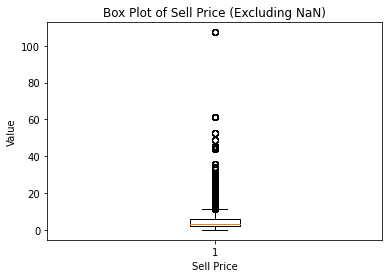

In [68]:
# Filter out NaN values from sell_price column
sell_price_filtered = sales_df["sell_price"].dropna()

# Create a box plot of filtered sell_price
plt.boxplot(sell_price_filtered)

# Set the title and labels
plt.title("Box Plot of Sell Price (Excluding NaN)")
plt.xlabel("Sell Price")
plt.ylabel("Value")

# Display the plot
plt.show()

In [69]:
sell_price_stats = sales_df["sell_price"].describe()
sell_price_stats

count    4.602796e+07
mean     4.408089e+00
std      3.403657e+00
min      1.000000e-02
25%      2.180000e+00
50%      3.470000e+00
75%      5.840000e+00
max      1.073200e+02
Name: sell_price, dtype: float64

In [70]:
# Filling NaN sell_price with 0 to represent absence of sell price
sales_df['sell_price'] = sales_df['sell_price'].fillna(0)

<span id="final-adjustments-to-sales-df-and-saving" style="font-size: 30px; font-weight: bold;">Final Adjustments to sales_df and Saving </span>

<span style="font-size: 16px;">Dropping redundant columns </span>

In [71]:
sales_df = sales_df.drop('wm_yr_wk', axis=1)

In [72]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   day           object        
 7   units_sold    int64         
 8   date          datetime64[ns]
 9   weekday       category      
 10  event_name_1  category      
 11  event_type_1  category      
 12  event_name_2  category      
 13  event_type_2  category      
 14  snap_CA       uint8         
 15  snap_TX       uint8         
 16  snap_WI       uint8         
 17  sell_price    float64       
dtypes: category(11), datetime64[ns](1), float64(1), int64(1), object(1), uint8(3)
memory usage: 3.0+ GB


<span style="font-size: 16px;">Sorting dataset for time series </span>

In [73]:
sales_df = sales_df.sort_values(by=["id", "date"])

In [74]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,units_sold,date,weekday,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
1612,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3,2011-01-29,Saturday,no_promo,no_promo,no_promo,no_promo,0,0,0,2.0
32102,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0,2011-01-30,Sunday,no_promo,no_promo,no_promo,no_promo,0,0,0,2.0
62592,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0,2011-01-31,Monday,no_promo,no_promo,no_promo,no_promo,0,0,0,2.0
93082,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1,2011-02-01,Tuesday,no_promo,no_promo,no_promo,no_promo,1,1,0,2.0
123572,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4,2011-02-02,Wednesday,no_promo,no_promo,no_promo,no_promo,1,0,1,2.0


<span style="font-size: 16px;">Saving the clean dataset </span>

In [ ]:
# Define the directory path
output_dir = Path("C:/Users/brian/Desktop/Time Series Predict Unit Sales for Walmart/Clean Dataset")

# Specify the file path for the Parquet file
output_file = output_dir / "data.parquet"

# Save sales_df as a Parquet file with partitioning
sales_df.to_parquet(
    output_file,
    index=False,
    engine="pyarrow",
    partition_cols=["store_id"]
)

<span id="summary" style="font-size: 30px; font-weight: bold;">Data Wrangling Summary </span>

<span style="font-size: 16px;">During the initial stage of data wrangling, I began by loading the sales, calendar events, and price datasets. To optimize memory usage and prepare the data for time series modeling, I performed necessary modifications to the data types. Subsequently, I conducted a thorough check for missing values within the datasets. In particular, I discovered that the calendar_df was lacking categorical information pertaining to event names and types. To address this, I introduced a new category called "no_promo" and assigned it to all the NaN values. This categorization signifies that there were no special promotions listed for those specific days.</span>

<span style="font-size: 16px;">My focus moved on to merging the three datasets into one dataset called sales_df. The process involved several steps. Firstly, I transformed the original sales_df into a panel view, consolidating the columns representing different days into a single column containing observations from d_1 to d_1913. Next, I performed a right join between the sales data and the calendar_df using their shared "day" column. Lastly, I carried out a left join to merge the price dataframe with sales_df. This merge ensured that all observations from the sales data were retained while incorporating the corresponding sell prices from the price dataframe. As a result, the final dataset, sales_df, was obtained.</span>

<span style="font-size: 16px;">I made several final adjustments to the consolidated sales_df dataset. First, I replaced any NaN values in the sell_price column with zeros. Then, I removed redundant columns to streamline the dataset. To establish a time series, I sorted the dataset by "id" and "date". However, when attempting to save the file as a .csv, I encountered difficulties. As a solution, I familiarized myself with using a parquet file format and saved the dataset with partitions based on the store_id.</span>

<span style="font-size: 16px;">In conclusion the sales_df is a merged dataset containing sales, calendar, and promotion information and is prepared for further exploratory data analysis for time series modeling.</span>